In [8]:
from copy import deepcopy
from math import pi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, state_fidelity
import itertools
import inspect
import random
import math
import numpy as np
import time
import pylatexenc
import json
import matplotlib.pyplot as plt

In [6]:
def loadJson(nameFile:str):
    with open(nameFile, "r") as file:
        dados = json.load(file)
    return dados

In [4]:
def plotDataResult(seed:int):
    teste = loadJson(f"data/Seed_{seed}.json")
    bestFitness = [population[-1] for population in teste["fitnessPopulationGen"]]
    worseFitness = [population[0] for population in teste["fitnessPopulationGen"]]
    lowerBound = [max(0, teste["fitnessAvgPopulationGen"][x] - teste["fitnessStdPopulationGen"][x]) for x in range(len(teste["fitnessAvgPopulationGen"]))]
    uperBound = [min(1, teste["fitnessAvgPopulationGen"][x] + teste["fitnessStdPopulationGen"][x]) for x in range(len(teste["fitnessAvgPopulationGen"]))]
    plt.plot(bestFitness, label='Best fitness')
    plt.plot(teste["fitnessAvgPopulationGen"], label='Average fitness')
    plt.fill_between(range(len(lowerBound)), lowerBound, uperBound, alpha=0.2, color='b')
    plt.plot(worseFitness, label='Worse fitness', linestyle='--')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend(loc='lower left')
    plt.savefig(f"files/Teste_{seed}_Best_{round(bestFitness[-1], 6)}.png", format="png")
    plt.show()
    plt.clf()
    return teste

# Filtrando e Processando as Gates

In [11]:
def getGatesIntoModule(module):
    # Removidas por serem a mistura de várias gates e aumentar a depth: mcrx, mcry, mcrz
    removeString = ['barrier', 'pauli', 'append', 'cast','clear', 'compose','control', 'copy', 'decompose', 'delay', 'depth', 'draw', 'initialize', 'inverse', 'measure','power', 'repeat', 'reset', 'size','store', 'switch', 'tensor', 'unitary', 'width', 'mcrx', 'mcry', 'mcrz']
    # Talvez -> ctrl_state
    gates = [(name,cls) for name, cls in inspect.getmembers(module) if inspect.isfunction(cls) and not (name.count('add') or name.count('_'))]
    gates = [(name, cls) for name, cls in gates if not name in removeString]
    return gates

def getGatesWithTypesParameters(classes):
    classesLocal = deepcopy(classes)
    typesDict = {
        "QubitSpecifier": ["int"],
        "<class 'qiskit.circuit.quantumregister.Qubit'>": ["int"],
        "typing.Union[qiskit.circuit.quantumregister.QuantumRegister, typing.List[qiskit.circuit.quantumregister.Qubit]]": ["list[int]"],
        "Sequence[QubitSpecifier]": ["list[int]"],
        "QubitSpecifier | Sequence[QubitSpecifier] | None": ["int", "list[int]", "None"],
        "typing.Union[qiskit.circuit.quantumregister.QuantumRegister, typing.Tuple[qiskit.circuit.quantumregister.QuantumRegister, int], NoneType]": ["int", "list[int]", "None"],
        "typing.Union[qiskit.circuit.parameterexpression.ParameterExpression, float]": ["float"],
        "ParameterValueType": ["float"]
    }
    gatesParameters = {}
    parametersOk = ['vz', 'target_qubit1', 'vy', 'phi','vx', 'qargs', 'control_qubits', 'q_target', 'target_qubit2', 'qubits', 'theta', 'qubit2', 'q_controls', 'target_qubit','gamma', 'qubit', 'control_qubit3', 'control_qubit1', 'control_qubit', 'control_qubit2', 'qubit1', 'lam']
    # Iterando sobre os parâmetros
    for name, classe in classesLocal:
        init_signature = inspect.signature(classe)
        gatesParameters[name] = dict()
        for parameter_name, parameter in init_signature.parameters.items():
            if parameter_name in parametersOk:
                gatesParameters[name][parameter_name] = typesDict[str(parameter.annotation)]
    return gatesParameters

def getGatesWithCombinations(gates):
    gatesLocal = deepcopy(gates)
    for gatename, gateInfo in gatesLocal.items():
        valores = [list(v) for v in gateInfo.values()]
        combinacoes = itertools.product(*valores)
        gateInfo["info"] = {}
        # (Qubits, Parameters, Strs)
        gateInfo["info"]["combinations"] = [(x, x.count("int") + x.count("list[int]"), x.count("float"), x.count("str")) for x in combinacoes]
    return gatesLocal

In [12]:
classes = getGatesIntoModule(QuantumCircuit)
GATES_PARAMETERS = getGatesWithTypesParameters(classes)
GATES_PARAMETERS


{'ccx': {'control_qubit1': ['int'],
  'control_qubit2': ['int'],
  'target_qubit': ['int']},
 'ccz': {'control_qubit1': ['int'],
  'control_qubit2': ['int'],
  'target_qubit': ['int']},
 'ch': {'control_qubit': ['int'], 'target_qubit': ['int']},
 'cp': {'theta': ['float'], 'control_qubit': ['int'], 'target_qubit': ['int']},
 'crx': {'theta': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int']},
 'cry': {'theta': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int']},
 'crz': {'theta': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int']},
 'cs': {'control_qubit': ['int'], 'target_qubit': ['int']},
 'csdg': {'control_qubit': ['int'], 'target_qubit': ['int']},
 'cswap': {'control_qubit': ['int'],
  'target_qubit1': ['int'],
  'target_qubit2': ['int']},
 'csx': {'control_qubit': ['int'], 'target_qubit': ['int']},
 'cu': {'theta': ['float'],
  'phi': ['float'],
  'lam': ['float'],
  'gamma': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int'

In [13]:
GATES_PARAMETERS = getGatesWithCombinations(GATES_PARAMETERS)
GATES_PARAMETERS

{'ccx': {'control_qubit1': ['int'],
  'control_qubit2': ['int'],
  'target_qubit': ['int'],
  'info': {'combinations': [(('int', 'int', 'int'), 3, 0, 0)]}},
 'ccz': {'control_qubit1': ['int'],
  'control_qubit2': ['int'],
  'target_qubit': ['int'],
  'info': {'combinations': [(('int', 'int', 'int'), 3, 0, 0)]}},
 'ch': {'control_qubit': ['int'],
  'target_qubit': ['int'],
  'info': {'combinations': [(('int', 'int'), 2, 0, 0)]}},
 'cp': {'theta': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int'],
  'info': {'combinations': [(('float', 'int', 'int'), 2, 1, 0)]}},
 'crx': {'theta': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int'],
  'info': {'combinations': [(('float', 'int', 'int'), 2, 1, 0)]}},
 'cry': {'theta': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int'],
  'info': {'combinations': [(('float', 'int', 'int'), 2, 1, 0)]}},
 'crz': {'theta': ['float'],
  'control_qubit': ['int'],
  'target_qubit': ['int'],
  'info': {'combinations': [(('

# Testes

In [1]:

from src.Antigo import main

results = []
seed = 100

In [15]:
results += main.multProcessesTest(seed=seed, countTest=10, numQubits=4, maxDepth=16, minDepth=4, lenPopulation=200, countGenerations=1000, gatesParameters=GATES_PARAMETERS)


Iniciando todos
Fim de todos -- 9574.120843410492


In [2]:
testes = []

# Teste 100

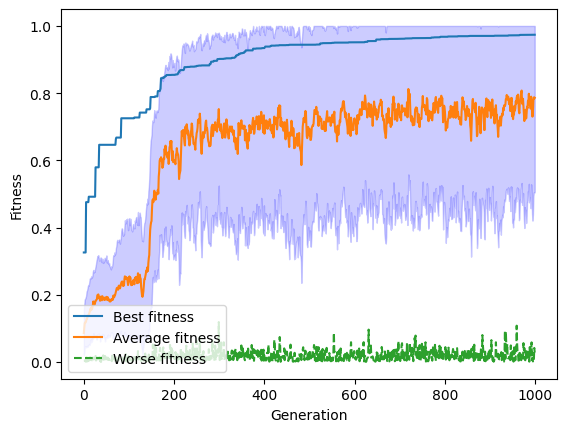

<Figure size 640x480 with 0 Axes>

In [9]:
testes.append(plotDataResult(seed))
seed+=1

In [18]:
bestCircuit, targetCircuit = results.pop(0)

## Target

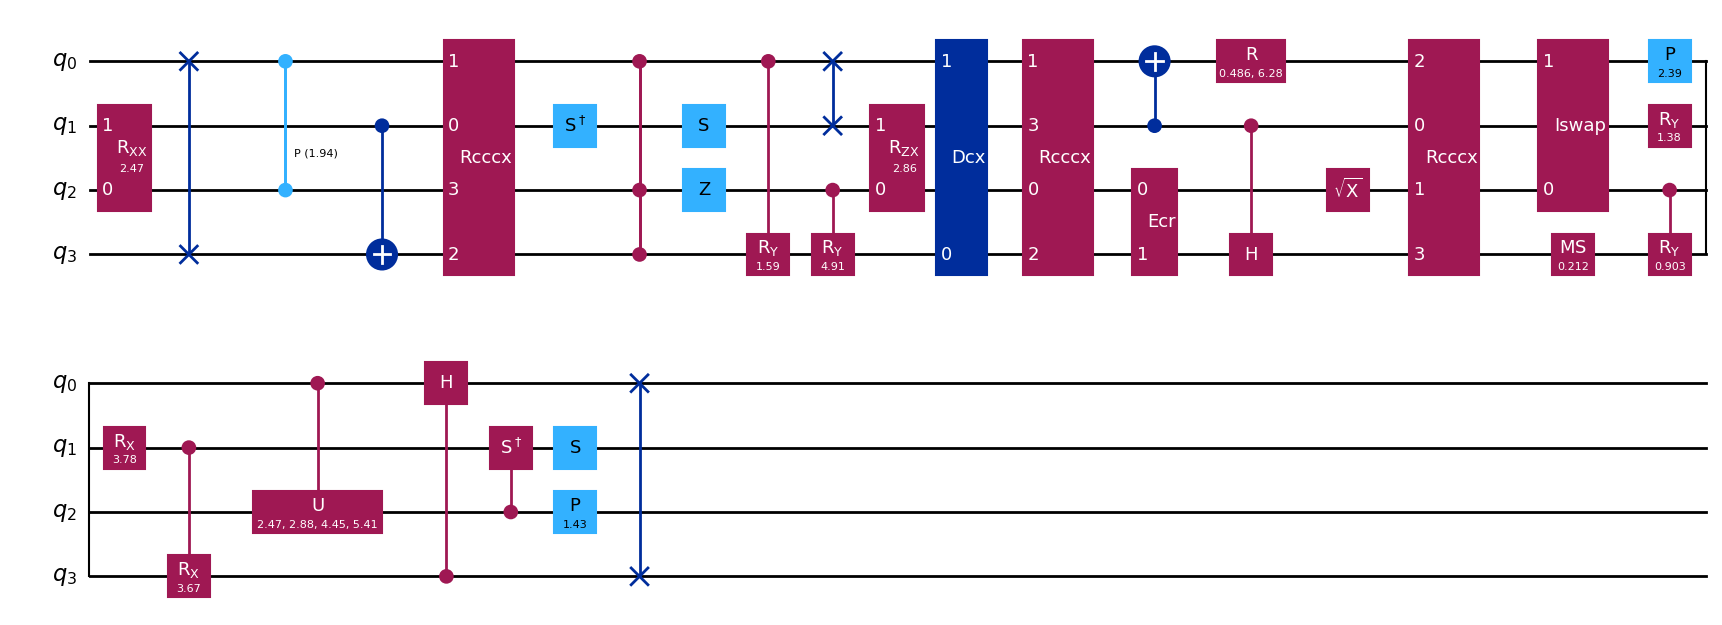

In [19]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 13] -- Fitness = 0.9737488165750554
    Profundidade:       [r] -> [2]   -----------  [['float', 1, 0.7396474727146898, <main.StepSize object at 0x00000204E7E81D90>], ['float', 1, 0.6580085607114688, <main.StepSize object at 0x00000204E7EE1F70>], ['int', 1, 2]]
       [ms] -> [3, 0]   -----------  [['float', 1, 0.08020425211868906, <main.StepSize object at 0x00000204E7EE2120>], ['list[int]', 2, [0, 3]]]
       [rz] -> [1]   -----------  [['float', 1, 0.9057038911758419, <main.StepSize object at 0x00000204E7EE2240>], ['int', 1, 1]]
    Profundidade:       [rxx] -> [1, 3]   -----------  [['float', 1, 0.784489572335183, <main.StepSize object at 0x00000204E7EE24B0>], ['int', 1, 3], ['int', 1, 1]]
       [cz] -> [0, 2]   -----------  [['int', 1, 2], ['int', 1, 0]]
    Profundidade:       [rzz] -> [3, 1]   -----------  [['float', 1, 1.3562134249454953, <main.StepSize object at 0x00000204E7EF8C20>], ['int', 1, 3], ['int', 1, 1]]
       [crz] -> [2, 0]   -----------  [['float', 1,

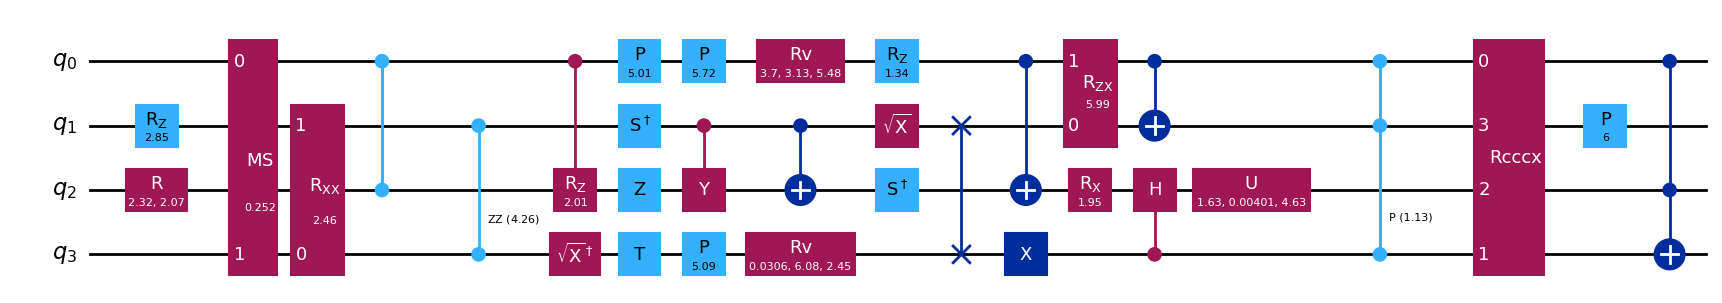

In [20]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 101

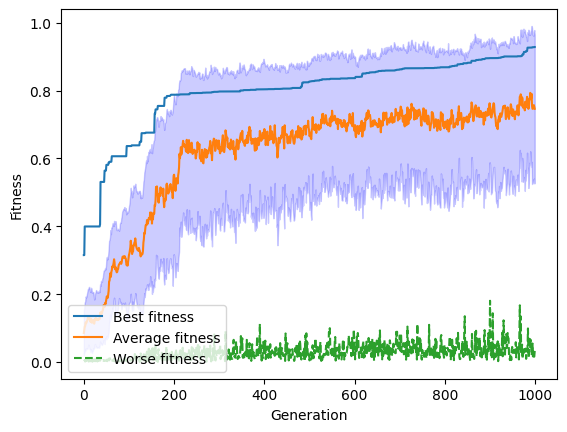

<Figure size 640x480 with 0 Axes>

In [10]:
testes.append(plotDataResult(seed))
seed+=1

In [22]:
bestCircuit, targetCircuit = results.pop(0)

## Target

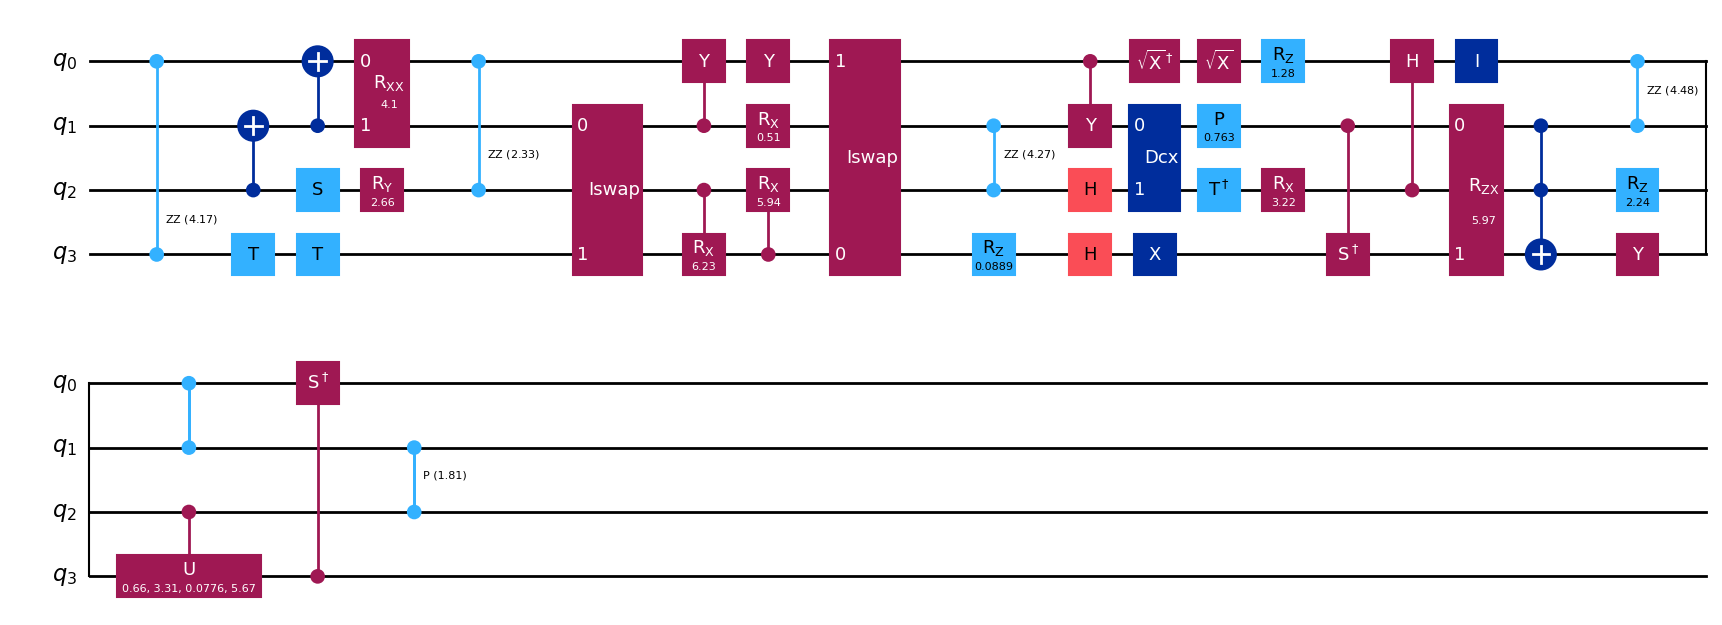

In [23]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 6] -- Fitness = 0.9286444376176798
    Profundidade:       [ry] -> [1]   -----------  [['float', 1, 0.17126052698193595, <main.StepSize object at 0x00000204E7EFA180>], ['int', 1, 1]]
       [ry] -> [0]   -----------  [['float', 1, 1.7366821416995706, <main.StepSize object at 0x00000204E7EFA420>], ['int', 1, 0]]
       [rx] -> [2]   -----------  [['float', 1, 1.9311794099531479, <main.StepSize object at 0x00000204E7EFA9C0>], ['int', 1, 2]]
       [ry] -> [3]   -----------  [['float', 1, 1.9408576712324344, <main.StepSize object at 0x00000204E7F105C0>], ['int', 1, 3]]
    Profundidade:       [ms] -> [1, 0, 3, 2]   -----------  [['float', 1, 0.39530906221565815, <main.StepSize object at 0x00000204E7F10AD0>], ['list[int]', 4, [3, 0, 1, 2]]]
    Profundidade:       [r] -> [0]   -----------  [['float', 1, 1.2773652096616785, <main.StepSize object at 0x00000204E7F10B90>], ['float', 1, 0.7376669538641125, <main.StepSize object at 0x00000204E7F10BF0>], ['int', 1, 0]]
       [sxdg] 

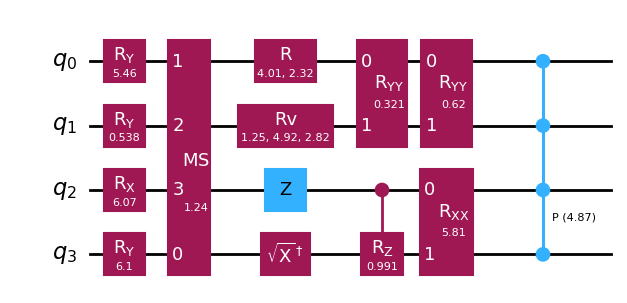

In [24]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 102

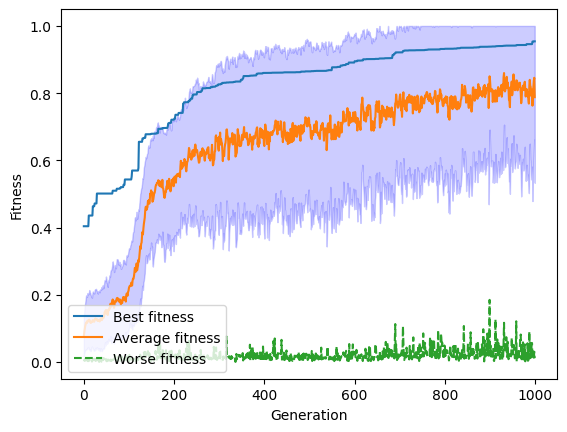

<Figure size 640x480 with 0 Axes>

In [11]:
testes.append(plotDataResult(seed))
seed+=1

In [26]:
bestCircuit, targetCircuit = results.pop(0)

## Target

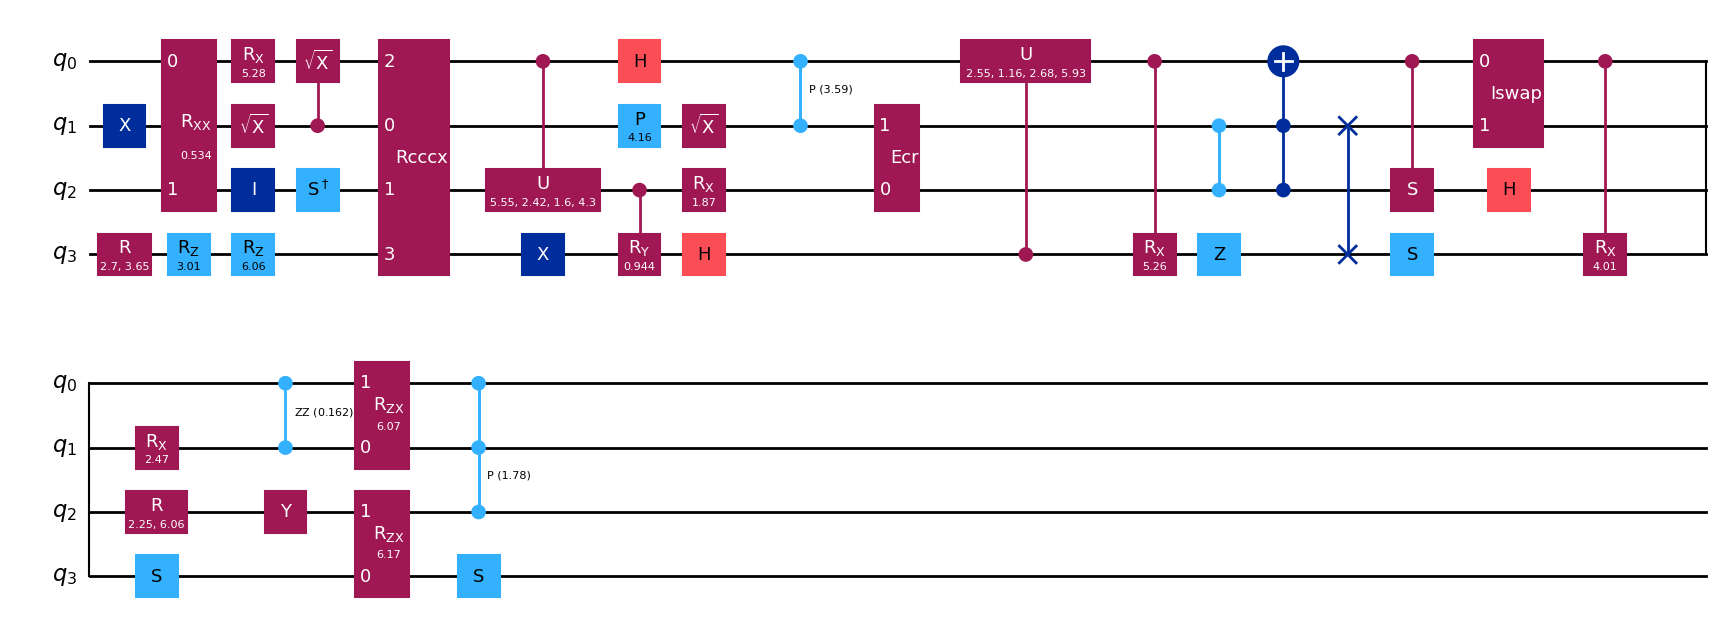

In [27]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 9] -- Fitness = 0.9540938966146246
    Profundidade:       [ms] -> [1, 3, 0]   -----------  [['float', 1, 0.3535976297951412, <main.StepSize object at 0x00000204E7E816D0>], ['list[int]', 3, [0, 1, 3]]]
       [sdg] -> [2]   -----------  [['int', 1, 2]]
    Profundidade:       [rz] -> [0]   -----------  [['float', 1, 0.4219267732537711, <main.StepSize object at 0x00000204E7E802C0>], ['int', 1, 0]]
       [u] -> [2]   -----------  [['float', 1, 1.561462622531865, <main.StepSize object at 0x00000204E7ED0950>], ['float', 1, 0.18729012287114905, <main.StepSize object at 0x00000204E7ED09B0>], ['float', 1, 0.8003567713375388, <main.StepSize object at 0x00000204E7ED0A10>], ['int', 1, 2]]
       [cp] -> [3, 1]   -----------  [['float', 1, 1.0851179998980238, <main.StepSize object at 0x00000204E7ED0B00>], ['int', 1, 1], ['int', 1, 3]]
    Profundidade:       [t] -> [2]   -----------  [['int', 1, 2]]
       [rx] -> [3]   -----------  [['float', 1, 0.9283483634282028, <main.StepSize o

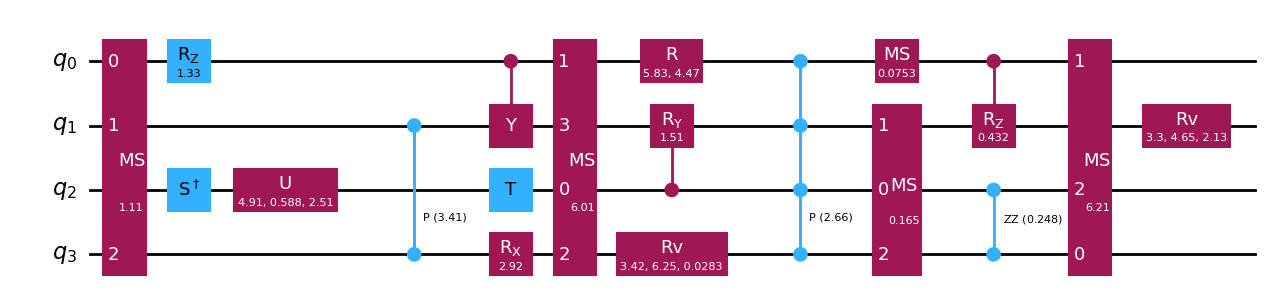

In [28]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 103

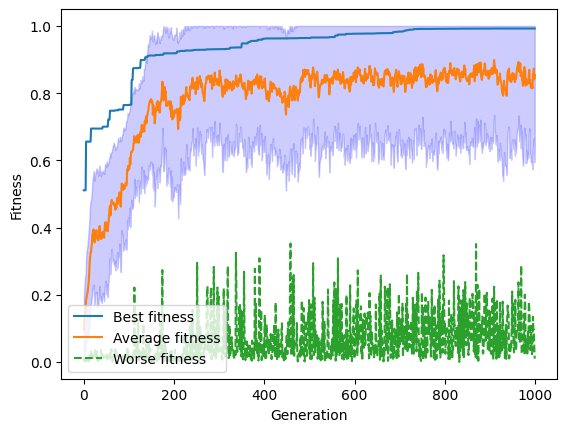

<Figure size 640x480 with 0 Axes>

In [12]:
testes.append(plotDataResult(seed))
seed+=1

In [30]:
bestCircuit, targetCircuit = results.pop(0)

## Target

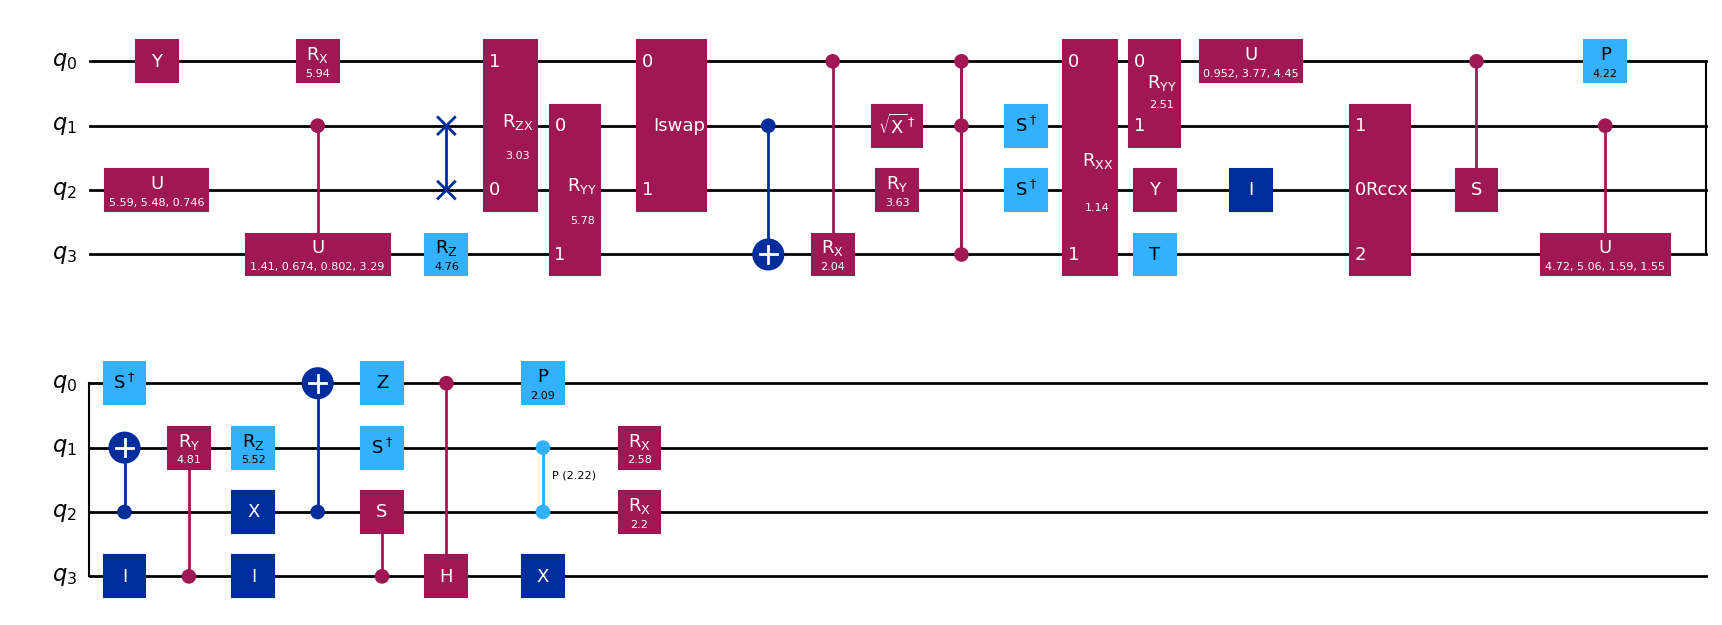

In [31]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 7] -- Fitness = 0.9923050299820798
    Profundidade:       [rv] -> [3]   -----------  [['float', 1, 1.6245720277411588, <main.StepSize object at 0x00000204E7E80B00>], ['float', 1, 0.0005030840780228252, <main.StepSize object at 0x00000204E7CB6AE0>], ['float', 1, 0.8486150320117978, <main.StepSize object at 0x00000204E7E80B90>], ['int', 1, 3]]
       [ms] -> [2]   -----------  [['float', 1, 1.5635067889958145, <main.StepSize object at 0x00000204E7E80C20>], ['list[int]', 1, [2]]]
       [crx] -> [1, 0]   -----------  [['float', 1, 0.13922381516810822, <main.StepSize object at 0x00000204E7E80CB0>], ['int', 1, 0], ['int', 1, 1]]
    Profundidade:       [rx] -> [1]   -----------  [['float', 1, 0.3677152097189255, <main.StepSize object at 0x00000204E7E80D40>], ['int', 1, 1]]
       [u] -> [2]   -----------  [['float', 1, 0.31143328670978754, <main.StepSize object at 0x00000204E7E80DA0>], ['float', 1, 0.49870414152518966, <main.StepSize object at 0x00000204E7E80DD0>], ['float', 1

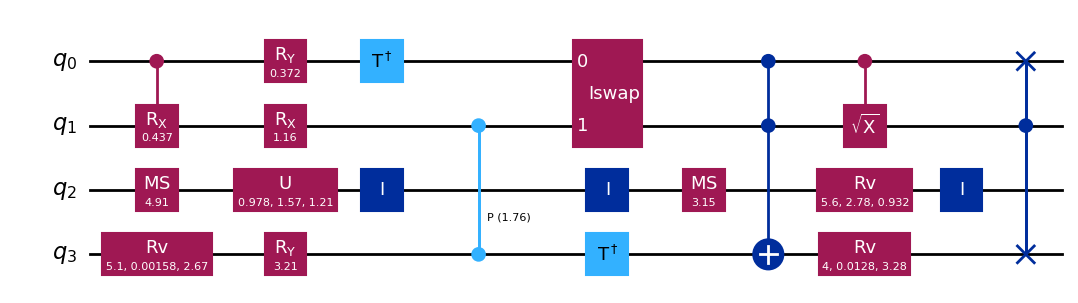

In [32]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 104

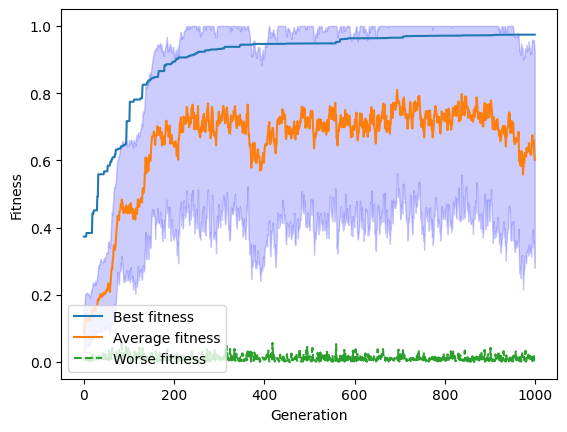

<Figure size 640x480 with 0 Axes>

In [13]:
testes.append(plotDataResult(seed))
seed+=1

In [34]:
bestCircuit, targetCircuit = results.pop(0)

## Target

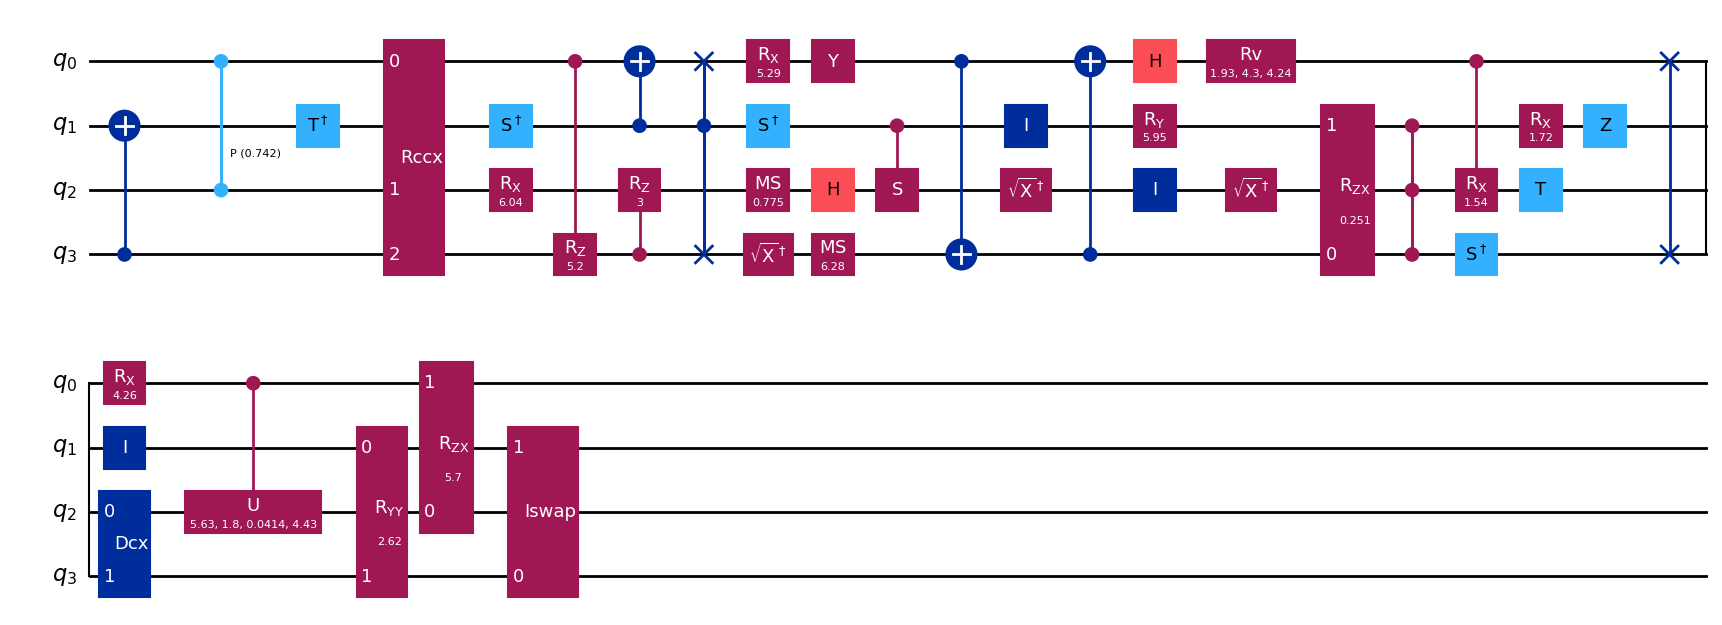

In [35]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 10] -- Fitness = 0.9740796907782482
    Profundidade:       [ms] -> [0, 1]   -----------  [['float', 1, 0.46558121132488883, <main.StepSize object at 0x00000204E7DF7650>], ['list[int]', 2, [0, 1]]]
       [rz] -> [3]   -----------  [['float', 1, 1.3089526935209985, <main.StepSize object at 0x00000204E7ED1C10>], ['int', 1, 3]]
       [z] -> [2]   -----------  [['int', 1, 2]]
    Profundidade:       [s] -> [0]   -----------  [['int', 1, 0]]
       [id] -> [3]   -----------  [['int', 1, 3]]
       [s] -> [1]   -----------  [['int', 1, 1]]
       [tdg] -> [2]   -----------  [['int', 1, 2]]
    Profundidade:       [rx] -> [0]   -----------  [['float', 1, 0.14909404413874414, <main.StepSize object at 0x00000204E7EE0CB0>], ['int', 1, 0]]
       [y] -> [2]   -----------  [['int', 1, 2]]
       [rxx] -> [1, 3]   -----------  [['float', 1, 0.05513497500939138, <main.StepSize object at 0x00000204E7EE0E00>], ['int', 1, 3], ['int', 1, 1]]
    Profundidade:       [swap] -> [2, 1]   ----

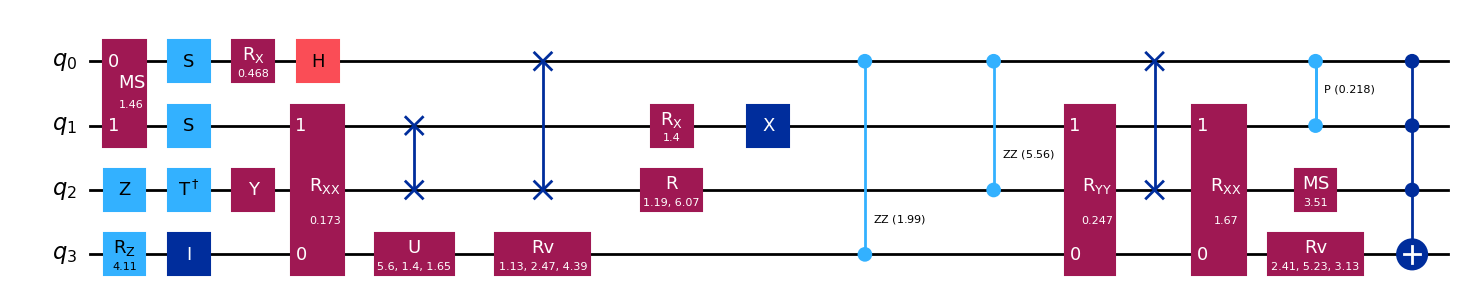

In [36]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 105

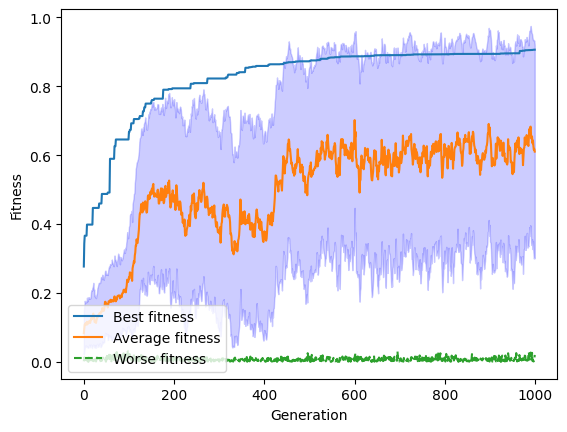

<Figure size 640x480 with 0 Axes>

In [14]:
testes.append(plotDataResult(seed))
seed+=1

In [38]:
bestCircuit, targetCircuit = results.pop(0)

## Target

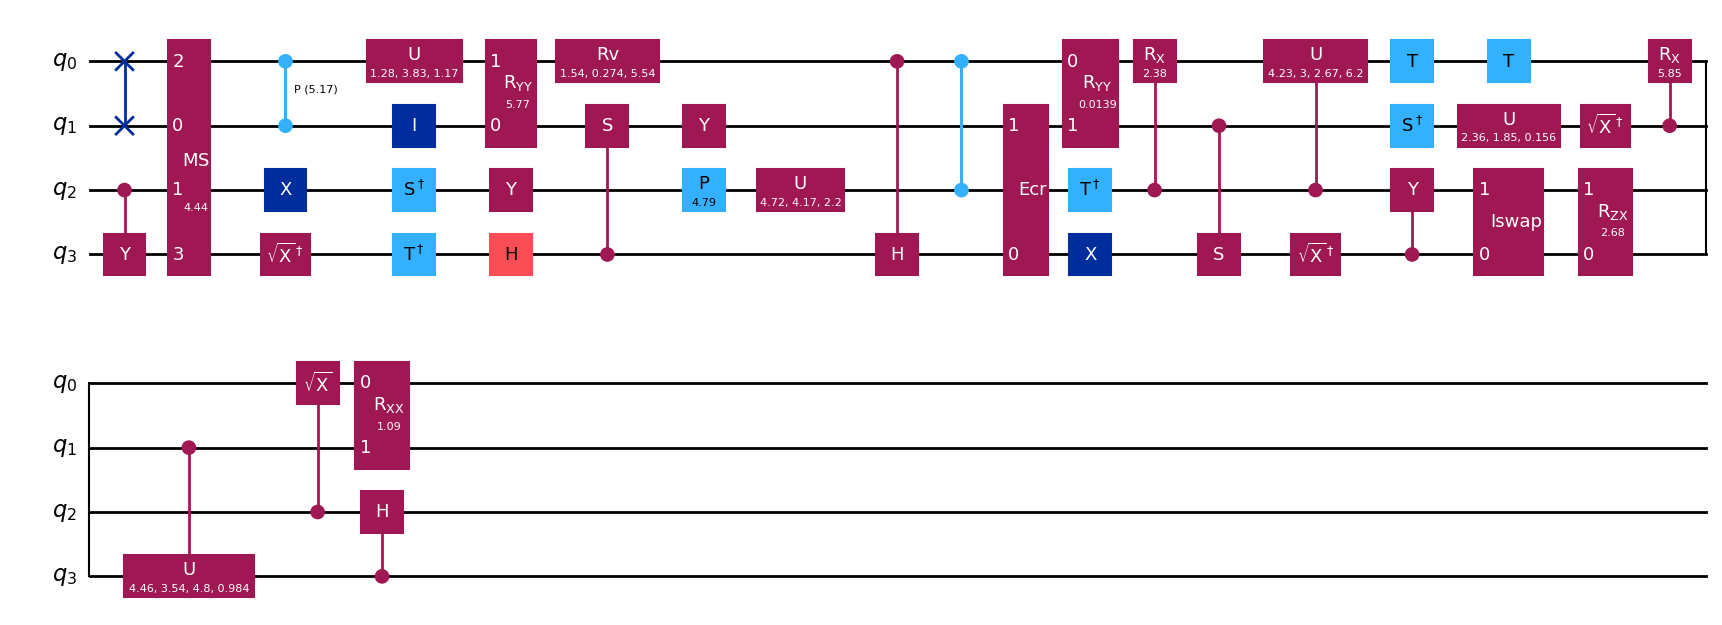

In [39]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 16] -- Fitness = 0.9058513986381062
    Profundidade:       [rxx] -> [0, 3]   -----------  [['float', 1, 1.8846043094843232, <main.StepSize object at 0x00000204E7F11640>], ['int', 1, 0], ['int', 1, 3]]
       [ecr] -> [2, 1]   -----------  [['int', 1, 2], ['int', 1, 1]]
    Profundidade:       [crx] -> [2, 3]   -----------  [['float', 1, 1.664416102536682, <main.StepSize object at 0x00000204E7F11850>], ['int', 1, 3], ['int', 1, 2]]
       [csdg] -> [0, 1]   -----------  [['int', 1, 1], ['int', 1, 0]]
    Profundidade:       [y] -> [0]   -----------  [['int', 1, 0]]
       [t] -> [3]   -----------  [['int', 1, 3]]
       [crx] -> [1, 2]   -----------  [['float', 1, 0.06934264160710701, <main.StepSize object at 0x00000204E7F2C170>], ['int', 1, 2], ['int', 1, 1]]
    Profundidade:       [ms] -> [0, 3]   -----------  [['float', 1, 1.8298003905636069, <main.StepSize object at 0x00000204E7F2C260>], ['list[int]', 2, [3, 0]]]
       [cy] -> [2, 1]   -----------  [['int', 1, 1], ['

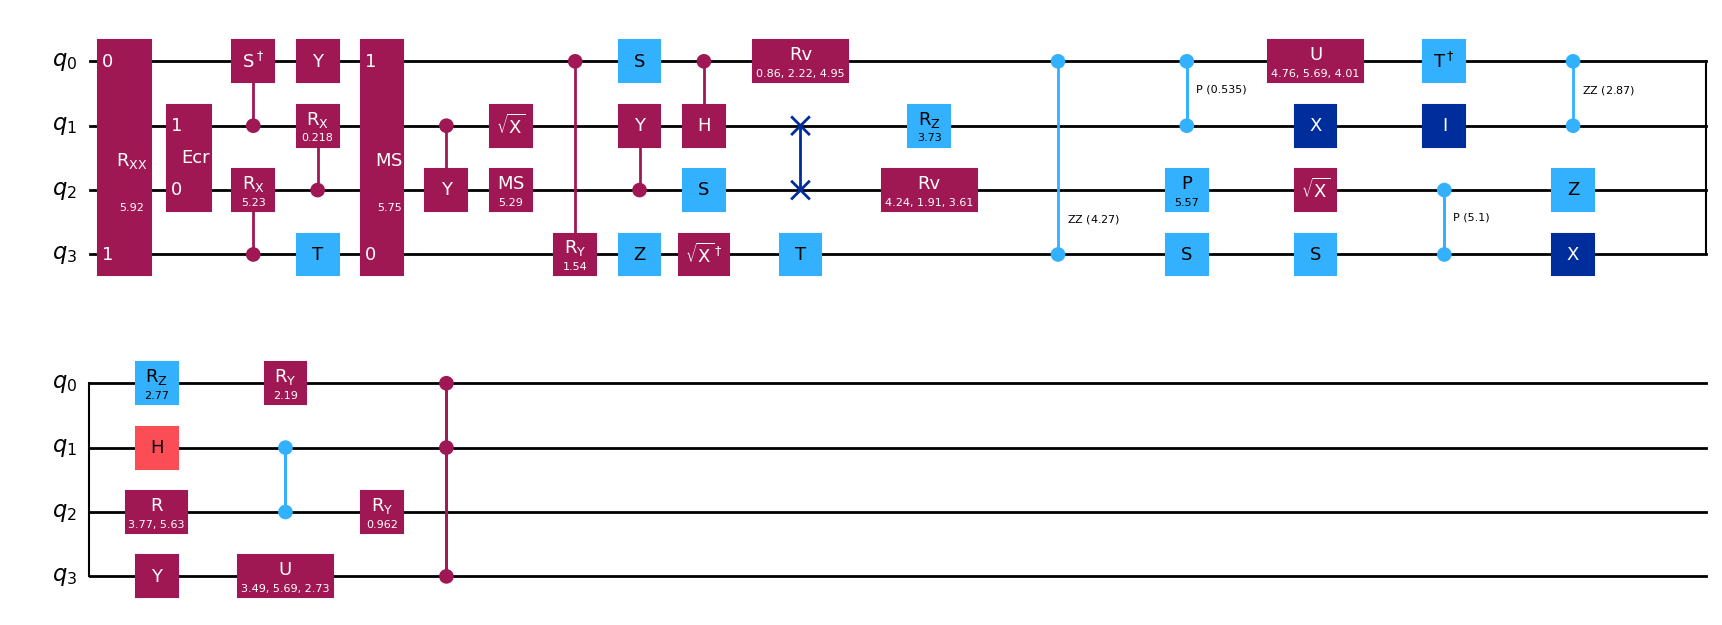

In [40]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 106

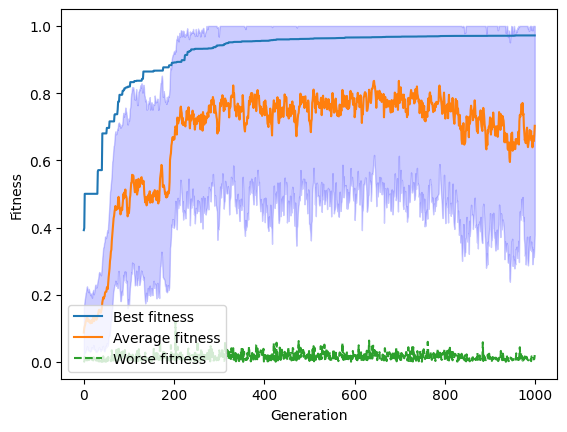

<Figure size 640x480 with 0 Axes>

In [15]:
testes.append(plotDataResult(seed))
seed+=1

In [42]:
bestCircuit, targetCircuit = results.pop(0)

## Target

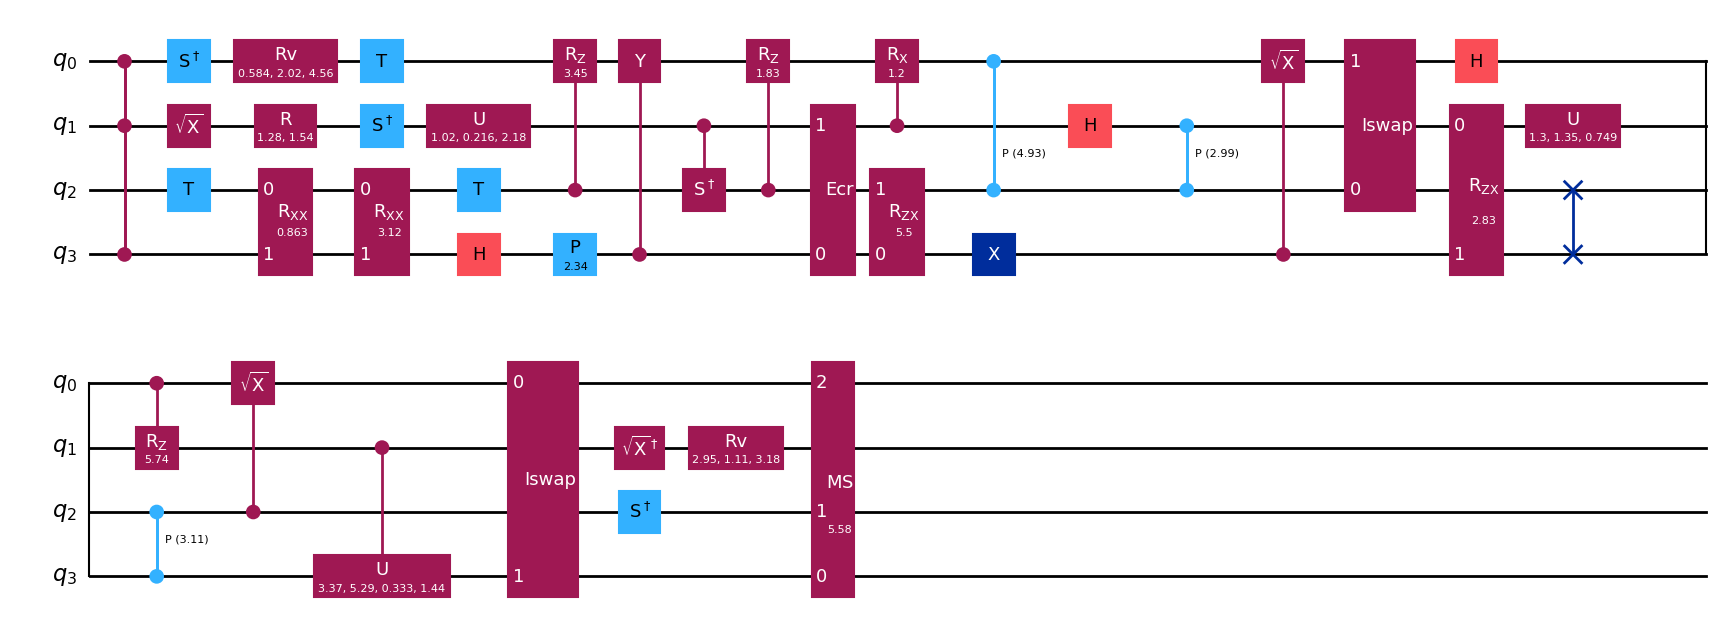

In [43]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 10] -- Fitness = 0.971698619352707
    Profundidade:       [ry] -> [2]   -----------  [['float', 1, 0.21062820107585054, <main.StepSize object at 0x00000204E7F2DDC0>], ['int', 1, 2]]
       [u] -> [0]   -----------  [['float', 1, 1.8037449526348492, <main.StepSize object at 0x00000204E7F2E150>], ['float', 1, 0.8372458822051108, <main.StepSize object at 0x00000204E7F2E780>], ['float', 1, 0.284821075686573, <main.StepSize object at 0x00000204E7F2E810>], ['int', 1, 0]]
       [rv] -> [3]   -----------  [['float', 1, 1.0147970480822823, <main.StepSize object at 0x00000204E7F450D0>], ['float', 1, 0.34289334502028856, <main.StepSize object at 0x00000204E7F45130>], ['float', 1, 1.3443674424468333, <main.StepSize object at 0x00000204E7F45190>], ['int', 1, 3]]
       [s] -> [1]   -----------  [['int', 1, 1]]
    Profundidade:       [sxdg] -> [0]   -----------  [['int', 1, 0]]
       [rz] -> [2]   -----------  [['float', 1, 0.19302610950028898, <main.StepSize object at 0x00000204E7F

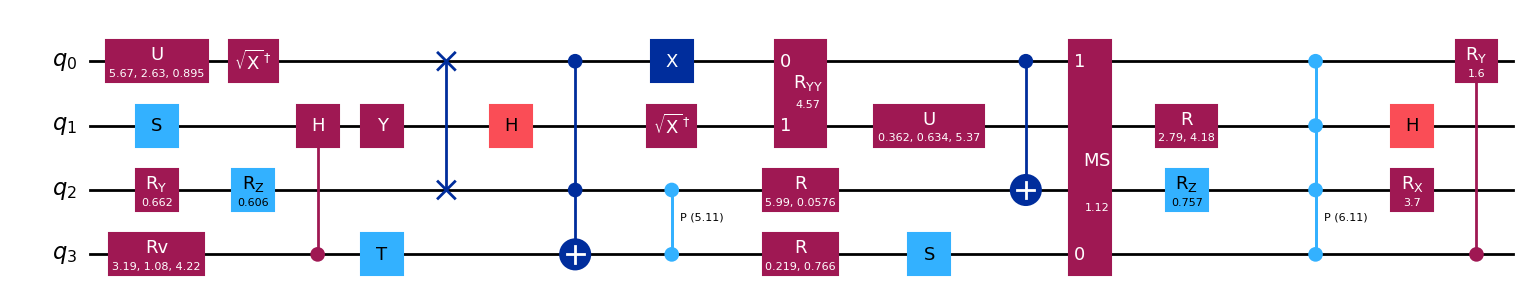

In [44]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 107

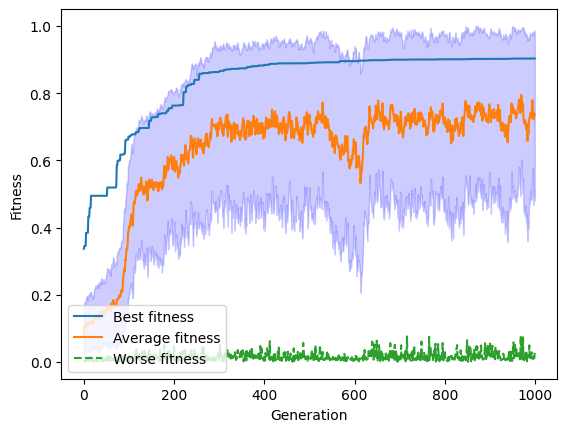

<Figure size 640x480 with 0 Axes>

In [16]:
testes.append(plotDataResult(seed))
seed+=1

In [46]:
bestCircuit, targetCircuit = results.pop(0)

## Target

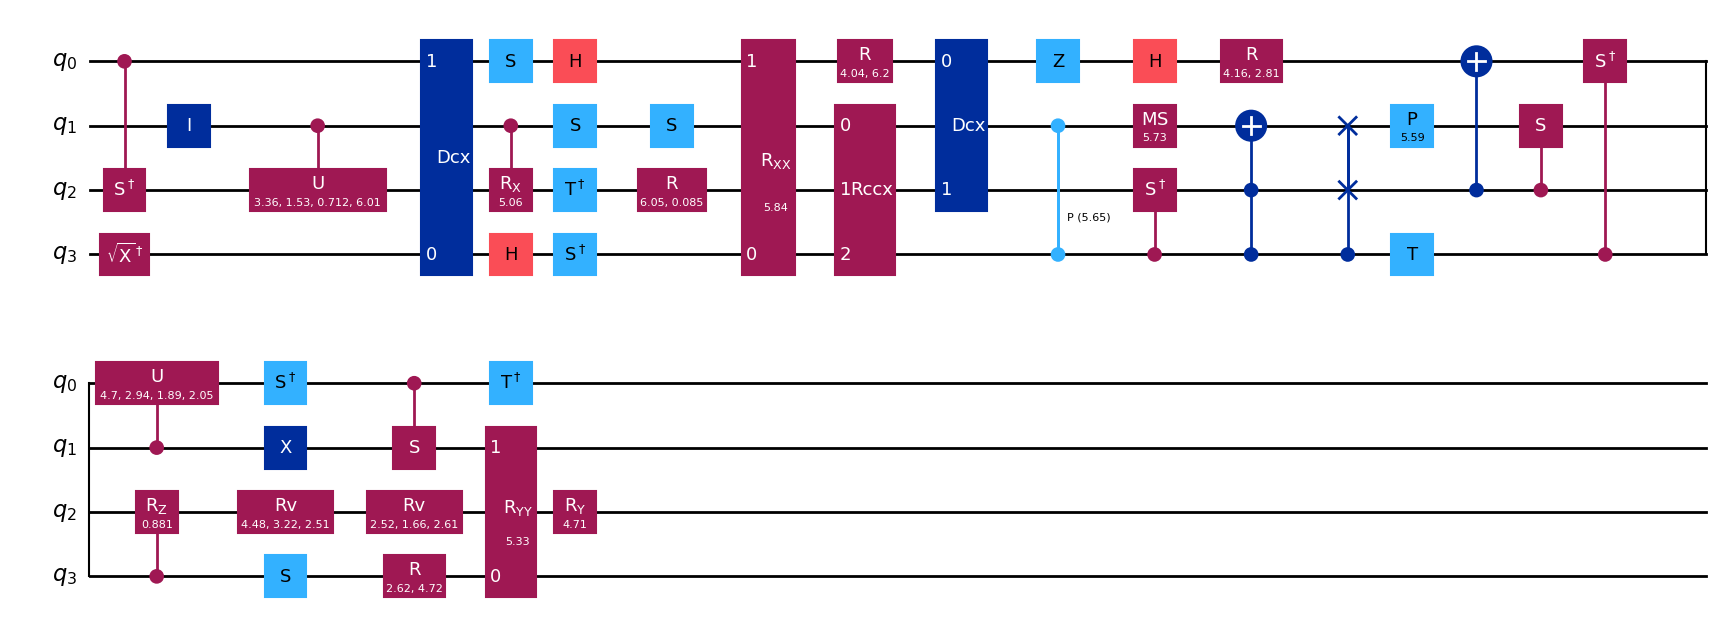

In [47]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 10] -- Fitness = 0.9030848752280285
    Profundidade:       [h] -> [0]   -----------  [['int', 1, 0]]
       [ry] -> [1]   -----------  [['float', 1, 1.4294022848602668, <main.StepSize object at 0x00000204E7F6EA20>], ['int', 1, 1]]
       [ry] -> [2]   -----------  [['float', 1, 1.9784106604296465, <main.StepSize object at 0x00000204E7F6EBD0>], ['int', 1, 2]]
       [rz] -> [3]   -----------  [['float', 1, 1.9891401437780472, <main.StepSize object at 0x00000204E7F817C0>], ['int', 1, 3]]
    Profundidade:       [rzz] -> [2, 1]   -----------  [['float', 1, 0.7304497397756398, <main.StepSize object at 0x00000204E7F81E20>], ['int', 1, 1], ['int', 1, 2]]
       [u] -> [0]   -----------  [['float', 1, 0.05815812400036949, <main.StepSize object at 0x00000204E7F81EE0>], ['float', 1, 0.08075230104001344, <main.StepSize object at 0x00000204E7F81F40>], ['float', 1, 1.5000969855157376, <main.StepSize object at 0x00000204E7F81FA0>], ['int', 1, 0]]
       [rv] -> [3]   -----------  [['f

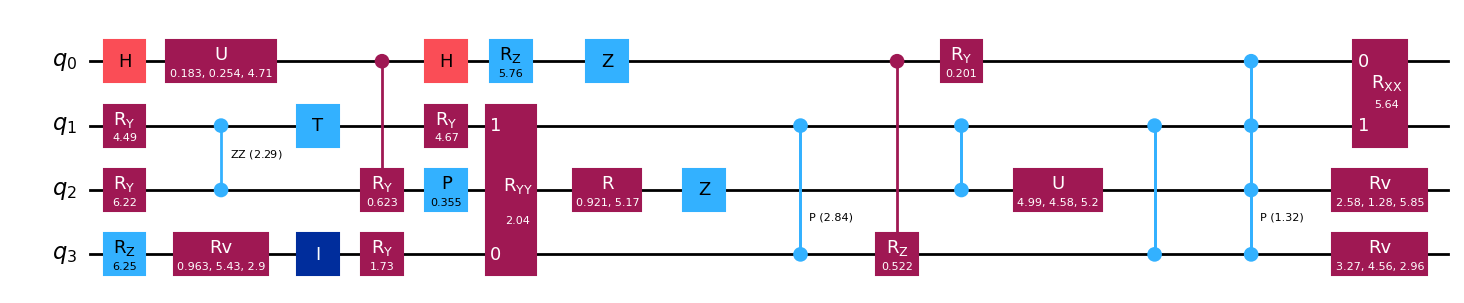

In [48]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 108

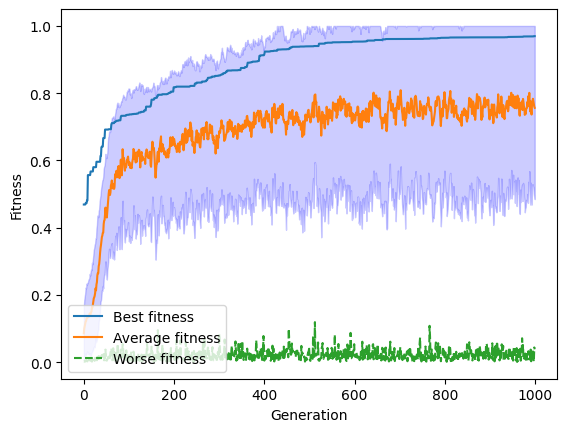

<Figure size 640x480 with 0 Axes>

In [17]:
testes.append(plotDataResult(seed))
seed+=1

In [50]:
bestCircuit, targetCircuit = results.pop(0)

## Target

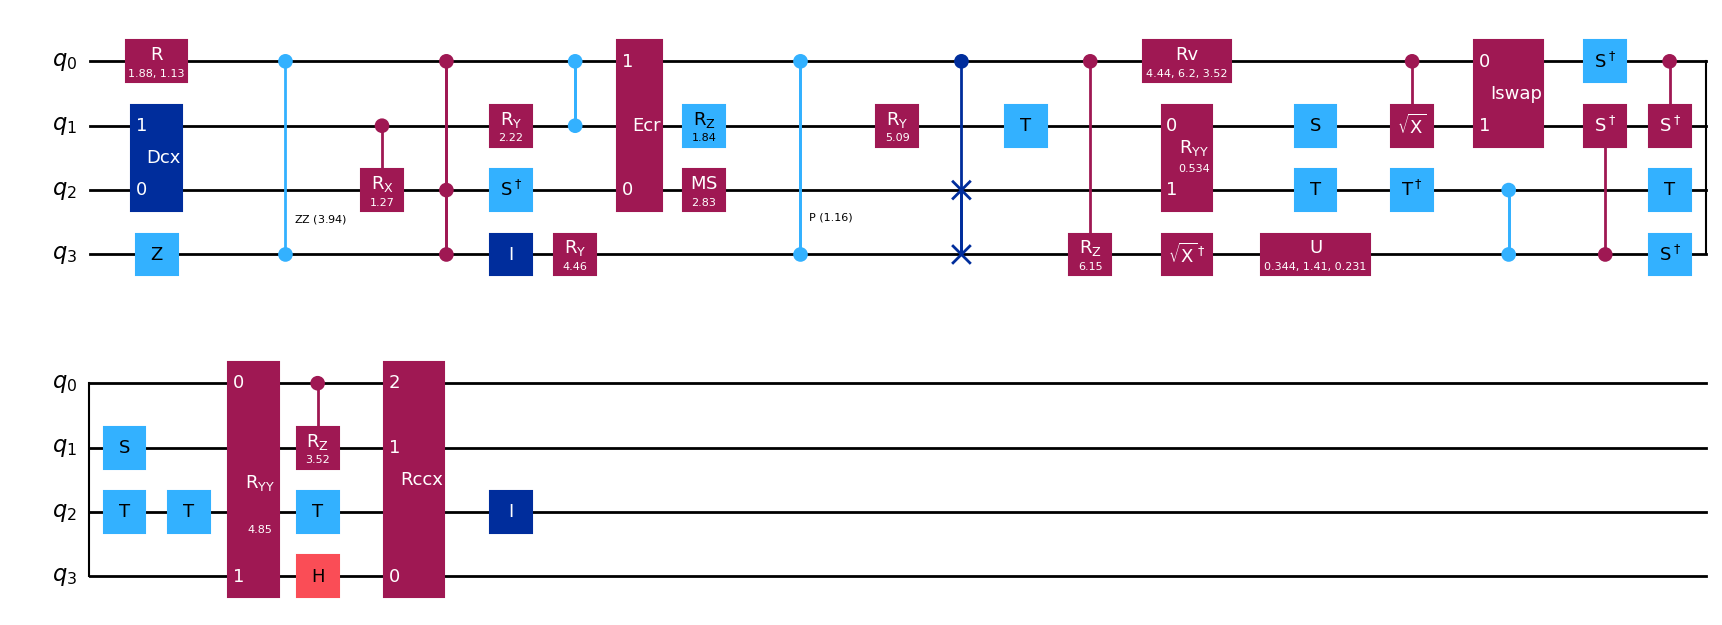

In [51]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 11] -- Fitness = 0.9695440354041822
    Profundidade:       [ryy] -> [3, 2]   -----------  [['float', 1, 1.769981706887718, <main.StepSize object at 0x00000204E7F463F0>], ['int', 1, 3], ['int', 1, 2]]
       [rv] -> [0]   -----------  [['float', 1, 0.12469254833547988, <main.StepSize object at 0x00000204E7F468A0>], ['float', 1, 0.05330930306656752, <main.StepSize object at 0x00000204E7F46840>], ['float', 1, 1.3332814460709006, <main.StepSize object at 0x00000204E7F468D0>], ['int', 1, 0]]
       [z] -> [1]   -----------  [['int', 1, 1]]
    Profundidade:       [s] -> [3]   -----------  [['int', 1, 3]]
       [sx] -> [1]   -----------  [['int', 1, 1]]
       [mcx] -> [0, 2]   -----------  [['list[int]', 1, [2]], ['int', 1, 0]]
    Profundidade:       [u] -> [1]   -----------  [['float', 1, 0.42380364044892727, <main.StepSize object at 0x00000204E7F59850>], ['float', 1, 0.9272463995216035, <main.StepSize object at 0x00000204E7F598B0>], ['float', 1, 1.2540742474587985, <main.S

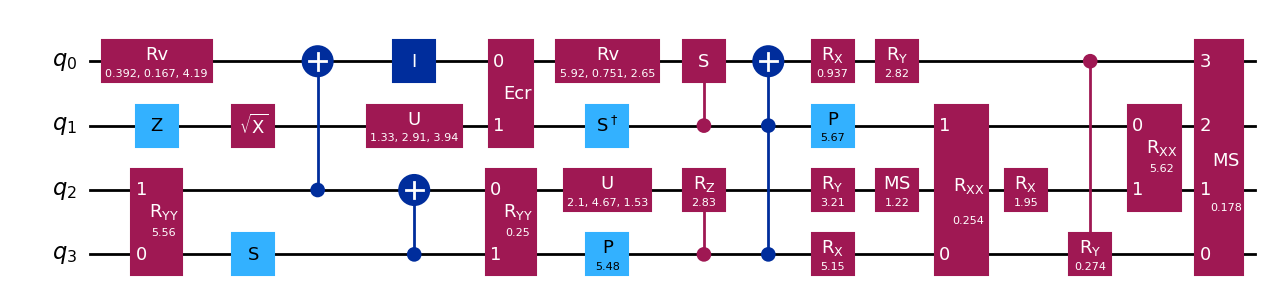

In [52]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# Teste 109

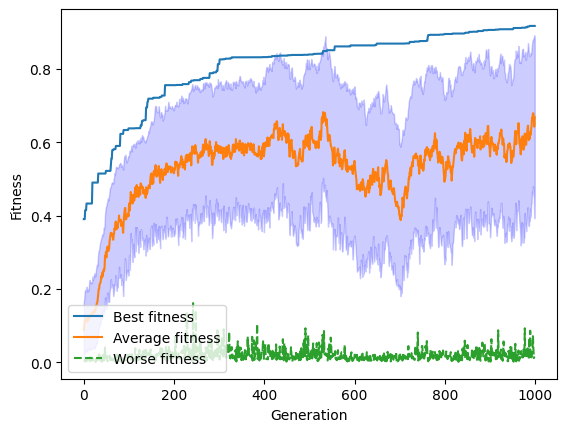

<Figure size 640x480 with 0 Axes>

In [18]:
testes.append(plotDataResult(seed))
seed+=1

In [54]:
bestCircuit, targetCircuit = results.pop(0)

## Target

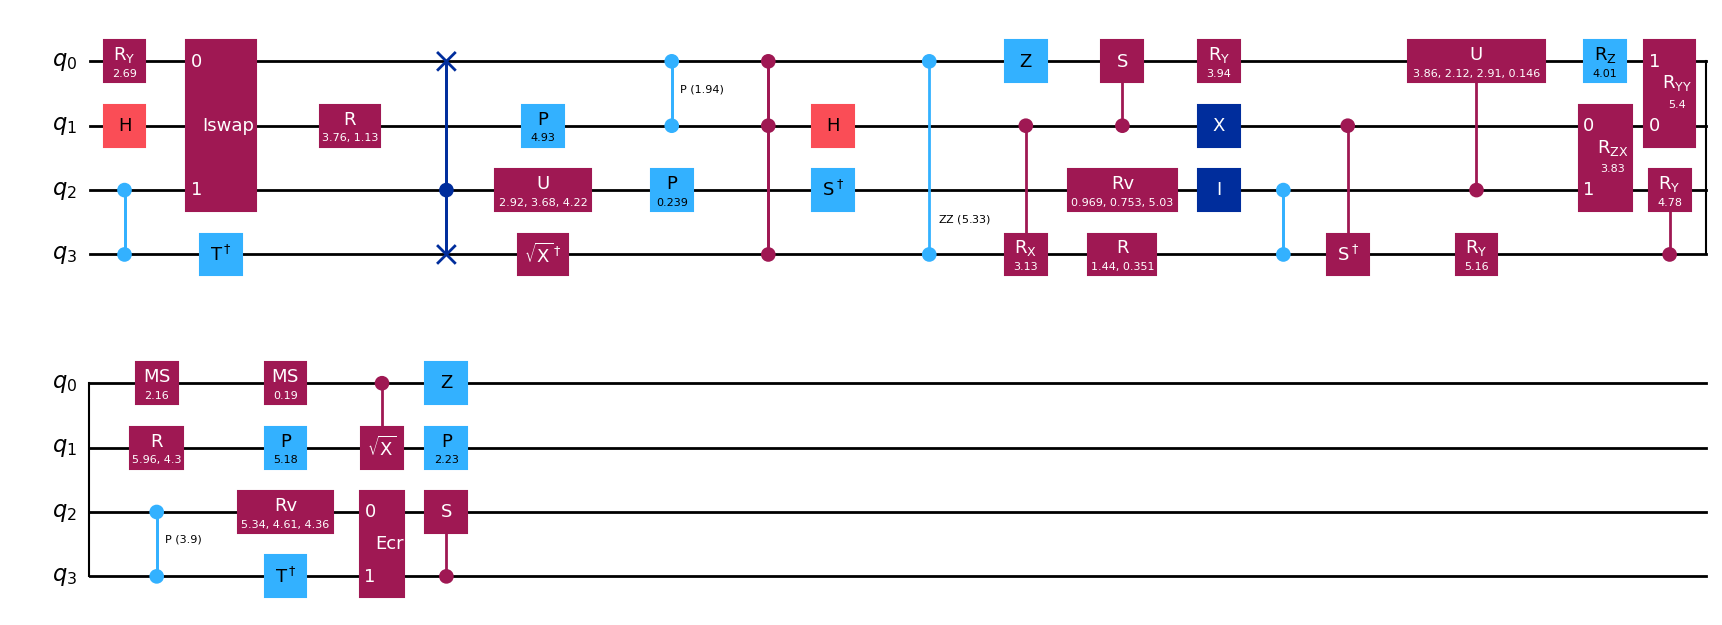

In [55]:
targetCircuit.circuit.draw("mpl")

## BestCircuit

Circuit [4 x 10] -- Fitness = 0.9171654976970824
    Profundidade:       [rxx] -> [0, 1]   -----------  [['float', 1, 0.2871650960844059, <main.StepSize object at 0x00000204E7D4B4A0>], ['int', 1, 1], ['int', 1, 0]]
       [ry] -> [2]   -----------  [['float', 1, 1.8223098312479769, <main.StepSize object at 0x00000204E7F5B0B0>], ['int', 1, 2]]
       [sdg] -> [3]   -----------  [['int', 1, 3]]
    Profundidade:       [rxx] -> [1, 2]   -----------  [['float', 1, 1.7007951511720607, <main.StepSize object at 0x00000204E7F6D610>], ['int', 1, 2], ['int', 1, 1]]
       [cu] -> [3, 0]   -----------  [['float', 1, 0.11335171950448197, <main.StepSize object at 0x00000204E7F6DC10>], ['float', 1, 1.3258409740324073, <main.StepSize object at 0x00000204E7F6DC70>], ['float', 1, 0.047651800416488, <main.StepSize object at 0x00000204E7F6DCD0>], ['float', 1, 0.36481693522400427, <main.StepSize object at 0x00000204E7F6DD30>], ['int', 1, 0], ['int', 1, 3]]
    Profundidade:       [rxx] -> [2, 3]   -------

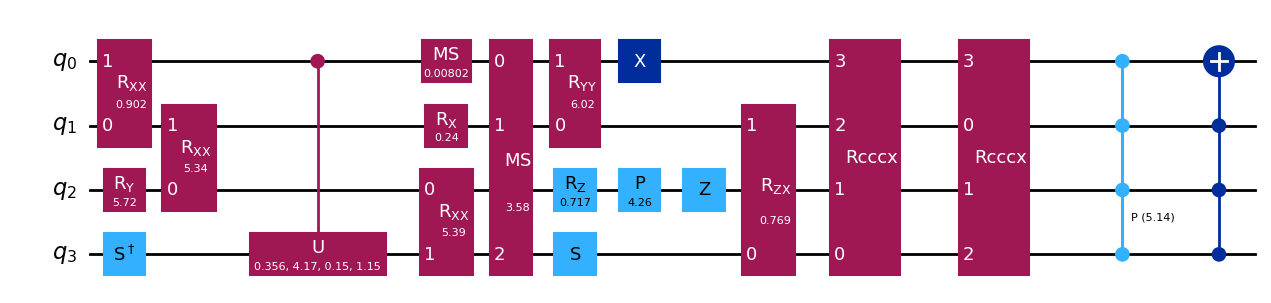

In [56]:
print(bestCircuit)
bestCircuit.circuit.draw("mpl")

# GLOBAL

In [57]:
bestFitness = [[] for _ in range(1000)]
avgFitness = [[] for _ in range(1000)]

for teste in testes:
    for gen in range(1000):
        bestFitness[gen].append(teste["fitnessPopulationGen"][gen][-1])
        avgFitness[gen].append(teste["fitnessAvgPopulationGen"][gen])

print(bestFitness[999])

bestFitness = [sum(x)/len(x) for x in bestFitness]
avgFitness = [sum(x)/len(x) for x in avgFitness]

print(avgFitness)

[0.9737488165750554, 0.9286444376176798, 0.9540938966146246, 0.9923050299820798, 0.9740796907782482, 0.9058513986381062, 0.971698619352707, 0.9030848752280285, 0.9695440354041822, 0.9171654976970824]
[0.08602344634824773, 0.09910001283217103, 0.11003124759796115, 0.11457891367143107, 0.11923111904398831, 0.12368453834080126, 0.12839227386052998, 0.13057479717888215, 0.1305742460628034, 0.13219684511784022, 0.1349089558531847, 0.13794136251991096, 0.14179458602382145, 0.1436640064560178, 0.14448405596176922, 0.14746345341805367, 0.15088657516479181, 0.15308294994801044, 0.15361859065780575, 0.16026938433125626, 0.16334740354042004, 0.16750602120829408, 0.16560029470565554, 0.16437484042240583, 0.16459667027429545, 0.16971514708757857, 0.1717954233775927, 0.17206238988532965, 0.1760726015240807, 0.17578968560169056, 0.18043496677547116, 0.1842324020440574, 0.18631165837064403, 0.1907158493623914, 0.19381760637715467, 0.19900775343375826, 0.19906826848464426, 0.2017969857464364, 0.2042340

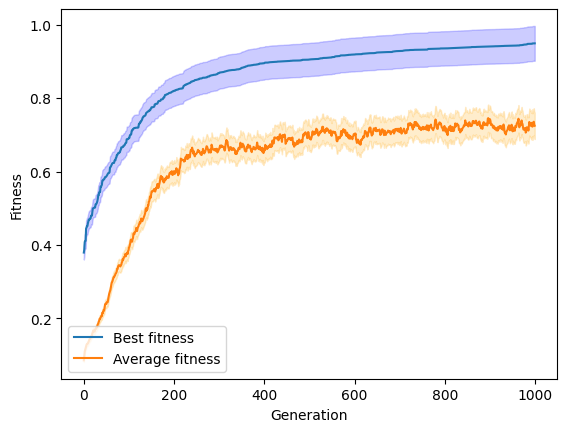

<Figure size 640x480 with 0 Axes>

In [58]:
plt.plot(bestFitness, label='Best fitness')
plt.plot(avgFitness, label='Average fitness')
plt.fill_between(range(1000), list(map(lambda x: x*1.05, bestFitness)), list(map(lambda x: x*0.95, bestFitness)), alpha=0.20, color='b')
plt.fill_between(range(1000), list(map(lambda x: x*1.05, avgFitness)), list(map(lambda x: x*0.95, avgFitness)), alpha=0.20, color='orange')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='lower left')
plt.savefig(f"files/Teste_Global_100-109.png", format="png")
plt.show()
plt.clf()

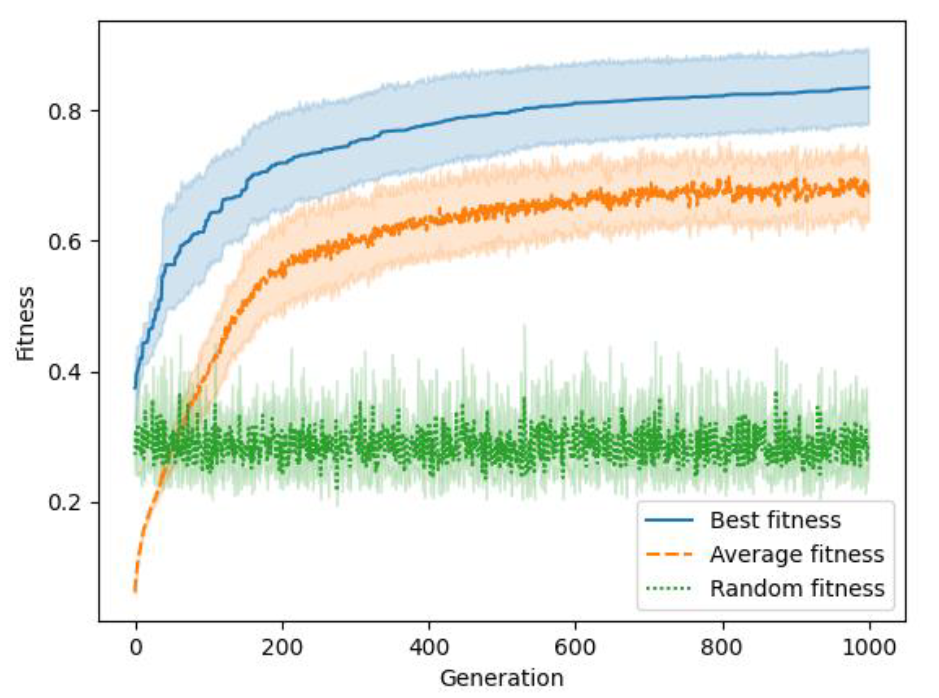

In [2]:
a = [0.9737488165750554, 0.9286444376176798, 0.9540938966146246, 0.9923050299820798, 0.9740796907782482, 0.9058513986381062, 0.971698619352707, 0.9030848752280285, 0.9695440354041822, 0.9171654976970824]
sum(a)/len(a)

0.9490216297887795